In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define create_dataset function
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Load and preprocess data
data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
data['date'] = pd.to_datetime(data['date'])
tunisia_data = data.loc[data['iso_code'] == 'TUN']
tunisia_data = tunisia_data[["date", "new_cases_smoothed"]]
tunisia_data = tunisia_data.set_index("date")
tunisia_data.dropna(inplace=True)
train_data = tunisia_data.loc[:"2022-02-28"]
test_data = tunisia_data.loc["2022-03-01":"2023-03-21"]
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

# Set time steps for RNN and KNN models
time_steps = 3

# Create KNN model
X_train_knn, y_train_knn = create_dataset(train_data_scaled, train_data_scaled["new_cases_smoothed"], time_steps)
X_test_knn, y_test_knn = create_dataset(test_data_scaled, test_data_scaled["new_cases_smoothed"], time_steps)
knn_model = KNeighborsRegressor(n_neighbors=7)
knn_model.fit(X_train_knn.reshape(X_train_knn.shape[0], -1), y_train_knn)
knn_predictions = knn_model.predict(X_test_knn.reshape(X_test_knn.shape[0], -1))
knn_predictions = scaler.inverse_transform(knn_predictions.reshape(-1, 1))

# Create RF model
X_train_rf, y_train_rf = create_dataset(train_data_scaled, train_data_scaled["new_cases_smoothed"], time_steps)
X_test_rf, y_test_rf = create_dataset(test_data_scaled, test_data_scaled["new_cases_smoothed"], time_steps)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf.reshape(X_train_rf.shape[0], -1), y_train_rf)
rf_predictions = rf_model.predict(X_test_rf.reshape(X_test_rf.shape[0], -1))
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

# Create RNN model
X_train_rnn, y_train_rnn = create_dataset(train_data_scaled, train_data_scaled["new_cases_smoothed"], time_steps)
X_test_rnn, y_test_rnn = create_dataset(test_data_scaled, test_data_scaled["new_cases_smoothed"], time_steps)
rnn_model = Sequential()
rnn_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
rnn_model.add(LSTM(units=50, return_sequences=True))



Epoch 1/100
22/22 [==============================] - 19s 172ms/step - loss: 0.5087 - val_loss: 3.0414
Epoch 2/100
22/22 [==============================] - 0s 12ms/step - loss: 0.1717 - val_loss: 0.2989
Epoch 3/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0276 - val_loss: 0.4530
Epoch 4/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0267 - val_loss: 0.2830
Epoch 5/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0234 - val_loss: 0.2541
Epoch 6/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0288 - val_loss: 0.2853
Epoch 7/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0224 - val_loss: 0.2837
Epoch 8/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0217 - val_loss: 0.2463
Epoch 9/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0212 - val_loss: 0.2353
Epoch 10/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0216 - val_loss: 0.22

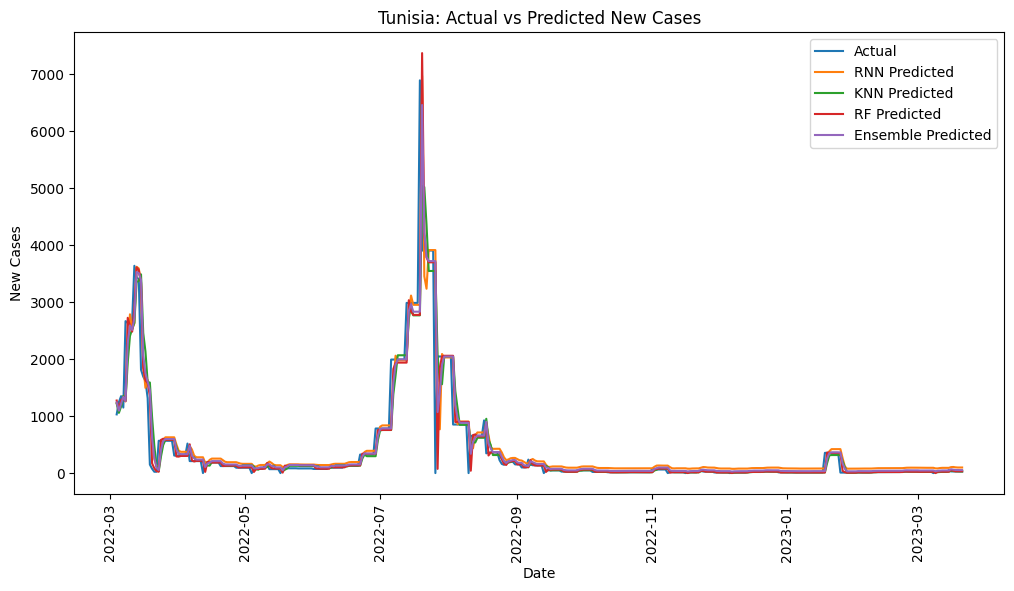

In [ ]:
rnn_model.add(LSTM(units=50))
rnn_model.add(Dense(units=1))

# Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
rnn_train_loss = rnn_model.evaluate(X_train_rnn, y_train_rnn, verbose=0)
rnn_test_loss = rnn_model.evaluate(X_test_rnn, y_test_rnn, verbose=0)

print(f"RNN Train Loss: {rnn_train_loss:.5f}")
print(f"RNN Test Loss: {rnn_test_loss:.5f}")

# Make predictions using RNN model
rnn_predictions = rnn_model.predict(X_test_rnn)
rnn_predictions = scaler.inverse_transform(rnn_predictions.reshape(-1, 1))
rnn_predictions_df = pd.DataFrame(rnn_predictions, index=test_data.index[time_steps:], columns=['new_cases_smoothed'])

# Create KNN model
knn_model = KNeighborsRegressor(n_neighbors=7)
knn_model.fit(X_train_knn.reshape(X_train_knn.shape[0], -1), y_train_knn)
knn_predictions = knn_model.predict(X_test_knn.reshape(X_test_knn.shape[0], -1))
knn_predictions = scaler.inverse_transform(knn_predictions.reshape(-1, 1))
knn_predictions_df = pd.DataFrame(knn_predictions, index=test_data.index[time_steps:], columns=['new_cases_smoothed'])

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Reshape the training and testing data to be 2-dimensional
X_train_rf = X_train_rf.reshape((X_train_rf.shape[0], -1))
X_test_rf = X_test_rf.reshape((X_test_rf.shape[0], -1))

# Create and train the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

test_data_rf = test_data_scaled.copy()
test_data_rf["new_cases_smoothed"] = test_data_scaled["new_cases_smoothed"].shift(-1*time_steps)
test_data_rf = test_data_rf.iloc[:-time_steps]

rf_predictions = rf_model.predict(X_test_rf)
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))
rf_predictions_df = pd.DataFrame(rf_predictions, index=pd.DataFrame(test_data_rf, index=test_data.index[time_steps:]).index, columns=['new_cases_smoothed'])



# Combine the predictions from all models
ensemble_predictions = (rnn_predictions_df['new_cases_smoothed'] + knn_predictions_df['new_cases_smoothed'] + rf_predictions_df['new_cases_smoothed']) / 3
ensemble_predictions_df = pd.DataFrame(ensemble_predictions, index=test_data.index[time_steps:], columns=['new_cases_smoothed'])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[time_steps:], test_data.values[time_steps:], label="Actual")
plt.plot(rnn_predictions_df.index, rnn_predictions_df.values, label="RNN Predicted")
plt.plot(knn_predictions_df.index, knn_predictions_df.values, label="KNN Predicted")
plt.plot(rf_predictions_df.index, rf_predictions_df.values, label="RF Predicted")
plt.plot(ensemble_predictions_df.index, ensemble_predictions_df.values, label="Ensemble Predicted")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("New Cases")
plt.title("Tunisia: Actual vs Predicted New Cases")
plt.legend()
plt.show()


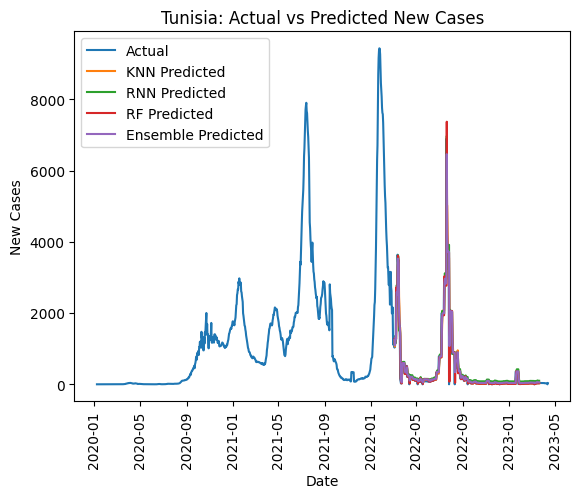

In [ ]:
plt.plot(tunisia_data.index, tunisia_data.values, label="Actual")
plt.plot(knn_predictions_df.index, knn_predictions_df.values, label="KNN Predicted")
plt.plot(rnn_predictions_df.index, rnn_predictions_df.values, label="RNN Predicted")
plt.plot(rf_predictions_df.index, rf_predictions_df.values, label="RF Predicted")
#plt.axvline(x='2022-03-01', c='black', ls='--', alpha=0.5)
plt.plot(ensemble_predictions_df.index, ensemble_predictions_df.values, label="Ensemble Predicted")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("New Cases")
plt.title("Tunisia: Actual vs Predicted New Cases")
plt.legend()
plt.show()


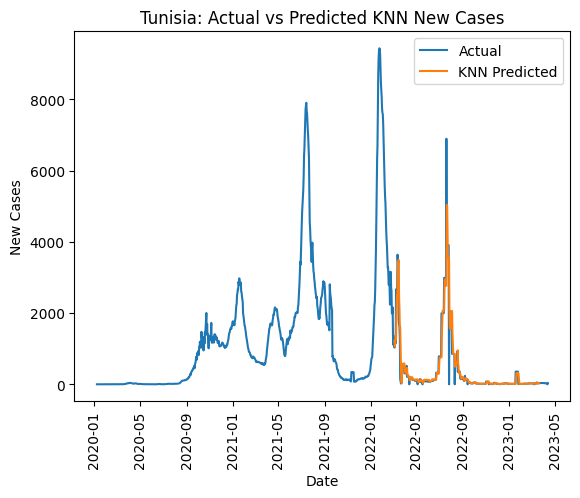

In [ ]:
plt.plot(tunisia_data.index, tunisia_data.values, label="Actual")
plt.plot(knn_predictions_df.index, knn_predictions_df.values, label="KNN Predicted")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("New Cases")
plt.title("Tunisia: Actual vs Predicted KNN New Cases")
plt.legend()
plt.show()

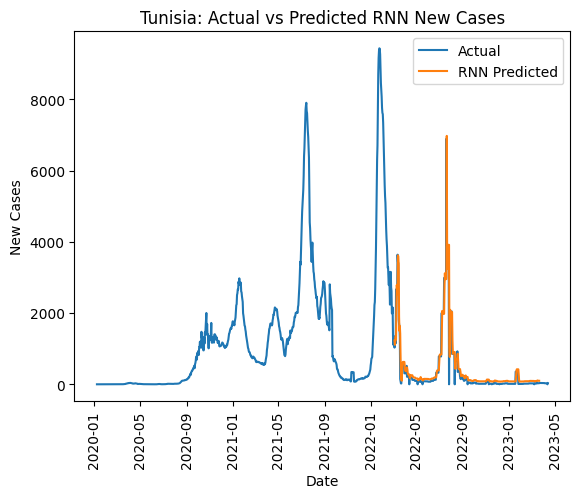

In [ ]:
plt.plot(tunisia_data.index, tunisia_data.values, label="Actual")
plt.plot(rnn_predictions_df.index, rnn_predictions_df.values, label="RNN Predicted")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("New Cases")
plt.title("Tunisia: Actual vs Predicted RNN New Cases")
plt.legend()
plt.show()


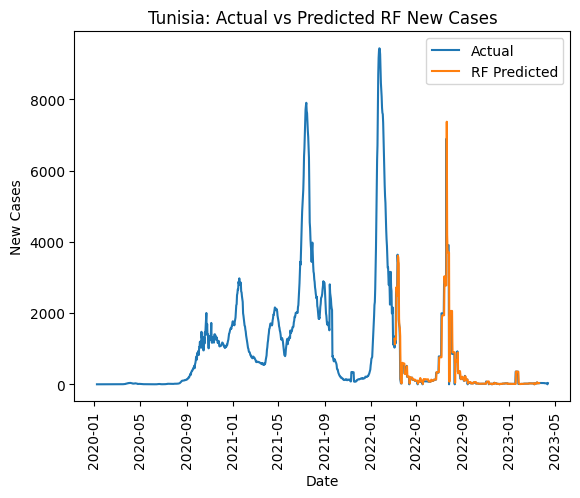

In [ ]:
plt.plot(tunisia_data.index, tunisia_data.values, label="Actual")
plt.plot(rf_predictions_df.index, rf_predictions_df.values, label="RF Predicted")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("New Cases")
plt.title("Tunisia: Actual vs Predicted RF New Cases")
plt.legend()
plt.show()


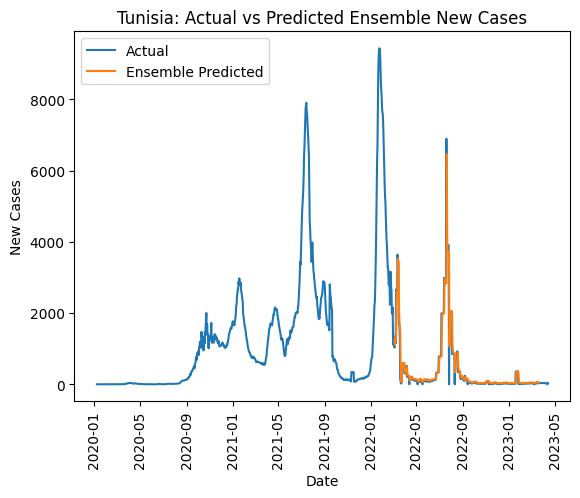

In [ ]:
plt.plot(tunisia_data.index, tunisia_data.values, label="Actual")
plt.plot(ensemble_predictions_df.index, ensemble_predictions_df.values, label="Ensemble Predicted")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("New Cases")
plt.title("Tunisia: Actual vs Predicted Ensemble New Cases")
plt.legend()
plt.show()